# Clustering Metro Station in Toulouse

In [1]:
#import requiered libraries
import folium
#import folium.plugins
import geopandas
from geopy.geocoders import Nominatim
import numpy as np
import pandas as pd
import requests
import geocoder
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

## 1. Preliminary steps

We first start by getting basic information about the metro stations in Toulouse and represent those on a map.
Additionaly, we will also extract several features from that dataset, in order to later be able to use the Foursquare API.

In [6]:
#find location of Toulouse using the Nominatim geocoder
address = 'Toulouse, France'

geolocator = Nominatim(user_agent = 'Toulouse_explorer')
location = geolocator.geocode(address)
latitude_T = location.latitude
longitude_T = location.longitude

In [7]:
#create a map of Toulouse
map_toulouse = folium.Map(location=[latitude_T, longitude_T], zoom_start=13)
map_toulouse

In [29]:
# load file with metro stations
geo_toulouse = r'stations-de-metro.geojson'

In [30]:
# represent metro station on the previously created map
folium.GeoJson(geo_toulouse, name='geojson').add_to(map_toulouse)
map_toulouse

In [31]:
# take the loaded fil with info about the metro station and convert it into a dataframe.
geo_metro = geopandas.read_file(geo_toulouse)
geo_metro.head()

,etat,commune,nom,ligne,couvert,en_service,type,geometry
0,Existant,TOULOUSE,BASSO CAMBO,A,Aérien,1993,Metro,POINT (1.39228 43.56996)
1,Existant,TOULOUSE,REYNERIE,A,Souterrain,1993,Metro,POINT (1.40173 43.57093)
2,Existant,TOULOUSE,CAPITOLE,A,Souterrain,1993,Metro,POINT (1.44527 43.60435)
3,Existant,TOULOUSE,ARGOULETS,A,Souterrain,2003,Metro,POINT (1.47674 43.62433)
4,Existant,TOULOUSE,UNIVERSITE PAUL SABATIER,B,Souterrain,2007,Metro,POINT (1.46310 43.56113)


Note that in order to be able to use the Foursquare API, we first need to extract the longitude and latitude (have separate columns). Indeed, for now the column geometry countains both information but we need to have those information in two separated columns.

In [32]:
geo_metro['longitude'] = geo_metro['geometry'].x #extract longitude from geometry column
geo_metro['latitude'] = geo_metro['geometry'].y # extract latitude from geometry column
geo_metro.head()

,etat,commune,nom,ligne,couvert,en_service,type,geometry,longitude,latitude
0,Existant,TOULOUSE,BASSO CAMBO,A,Aérien,1993,Metro,POINT (1.39228 43.56996),1.392278,43.569961
1,Existant,TOULOUSE,REYNERIE,A,Souterrain,1993,Metro,POINT (1.40173 43.57093),1.401730,43.570927
2,Existant,TOULOUSE,CAPITOLE,A,Souterrain,1993,Metro,POINT (1.44527 43.60435),1.445273,43.604350
3,Existant,TOULOUSE,ARGOULETS,A,Souterrain,2003,Metro,POINT (1.47674 43.62433),1.476740,43.624335
4,Existant,TOULOUSE,UNIVERSITE PAUL SABATIER,B,Souterrain,2007,Metro,POINT (1.46310 43.56113),1.463097,43.561132


In [33]:
print('There are {} different metro station in Toulouse.'.format(len(geo_metro['nom'].unique()))) #count how many unique metro station are in Toulouse

There are 43 different metro station in Toulouse.


In [107]:
print('There are {} different metro lines in Toulouse.'.format(len(geo_metro['ligne'].unique())))

There are 3 different metro lines in Toulouse.


## 2. Getting Venues using the Foursquare API

Now that we have all locations, we can start using the Foursquare API as to find venues located near metro stations

In [36]:
#load basic credential for later request.
CLIENT_ID = 'GESGNLYJKQSVKCU1JAK1SL21CP1YQ3X451UKKE0IHOUNSRNC' # your Foursquare ID
CLIENT_SECRET = 'P05FCU3KZXDO1NOWC0TC2UZVTAENXFGAWSCA12ITNJ4BAZ24' # your Foursquare Secret
VERSION = '20191207' # Foursquare API version

LIMIT = 500

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GESGNLYJKQSVKCU1JAK1SL21CP1YQ3X451UKKE0IHOUNSRNC
CLIENT_SECRET:P05FCU3KZXDO1NOWC0TC2UZVTAENXFGAWSCA12ITNJ4BAZ24


### 2.1 define the appropriate radius

a first methodological issue is to find the appropriate **radius** for queries. Indeed, we will later make some request by specifying both a location (longitude and latitude) and a radius. The Foursquare API will then return the venues within that circle. So we have to find a radius so that a venue do not appear in two different metro stations, otherwise, we will have a distorded view of the metro stations' surrounding. To get an idea of an appropriate radius, we then visualize the radius on a map.

In [37]:
map_radius = folium.Map(location=[latitude_T, longitude_T], zoom_start=13)

radius_group = folium.map.FeatureGroup()

#loop through dataset and display a circle
#note that the radius argument of "Circle" is in meter, and that of "CircleMarker" is not!
for lat, lng in zip(geo_metro['latitude'], geo_metro['longitude']):
    radius_group.add_child(
        folium.features.Circle(
            [lat, lng],
            radius=500,
            color='red'
            )
    )
#represent all metro station (center)
for lat, lng in zip(geo_metro['latitude'], geo_metro['longitude']):
    radius_group.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=3,
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7
            )
    )    

map_radius.add_child(radius_group)  
    

We face here a first drawback. Because while the radius of 500m is optimal for metro stations being outside of the city center, the metro stations being in the center will all belong to the same cluster group...
<br>
So let's try a **new radius of 350m**:

In [38]:
map_radius = folium.Map(location=[latitude_T, longitude_T], zoom_start=13)


#represent all metro station (center)
for lat, lng in zip(geo_metro['latitude'], geo_metro['longitude']):
    folium.features.CircleMarker(
            [lat, lng],
            radius=3,
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.7,
    ).add_to(map_radius)
  

#represent the radius
for lat, lng in zip(geo_metro['latitude'], geo_metro['longitude']):
    folium.Circle(
        [lat,lng],
        radius=350,
        color='red'
    ).add_to(map_radius)
    
#map_radius.add_child(radius_group)  
map_radius

Here the situation appears to be more acceptable than before. Whilst we still have overlapping radiuses in the city center, we considerably reduce the number of overlaps outside of the center. And it should be noted that it might not be problematic to have those overlaps in the city center as:
<br>
1. some stations are really near to each other so it makes sense that they also land in the same cluster, i.e. they are indeed comparable.
2. a small city center like in Toulouse is normally perceived as "a block" where you don't take the metro to navigate aroung the city center. So according to our business problem, it should not be problematic to have those overlaps in the center.

### 2.2 Find all movie theater

To find all movie theaters, we will make one single **explore request** by using the center of Toulouse and one appropriate radius. We use the following map to identify that radius

In [110]:
map_movie = folium.Map([latitude_T, longitude_T], zoom_start=12)
'''
folium.Circle(
    [latitude_T, longitude_T],
    radius=6000).add_to(map_movie)

map_movie
'''

'\nfolium.Circle(\n    [latitude_T, longitude_T],\n    radius=6000).add_to(map_movie)\n\nmap_movie\n'

In [42]:

radius=6000

CATEGORY_ID = '4bf58dd8d48988d17f941735' #category ID for movie theaters
    
url_movie = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                latitude_T, 
                longitude_T,
                CATEGORY_ID,
                radius, 
                LIMIT)

results_movie = requests.get(url_movie).json()["response"]["venues"]




In [43]:
theaters = pd.json_normalize(results_movie)
theaters.head()

,id,name,categories,referralId,hasPerk,location.address,location.lat,location.lng,location.labeledLatLngs,location.distance,location.postalCode,location.cc,location.city,location.state,location.country,location.formattedAddress,location.neighborhood
0,4bb74a63ef159c741ffb76f7,Cinéma Utopia,"[{'id': '4bf58dd8d48988d17e941735', 'name': 'I...",v-1599214264,False,24 Rue Montardy,43.604095,1.446715,"[{'label': 'display', 'lat': 43.6040946638791,...",203,31000,FR,Toulouse,Midi-Pyrénées,France,"[24 Rue Montardy, 31000 Toulouse, France]",NaN
1,4b8a8935f964a520297132e3,Gaumont Wilson,"[{'id': '4bf58dd8d48988d180941735', 'name': 'M...",v-1599214264,False,3 place du Président Thomas Wilson,43.604251,1.448624,"[{'label': 'display', 'lat': 43.60425144568281...",353,31000,FR,Toulouse,Midi-Pyrénées,France,"[3 place du Président Thomas Wilson, 31000 Tou...",NaN
2,4c0d40cf7189c928a9b8d6b6,La Cinémathèque de Toulouse,"[{'id': '4bf58dd8d48988d17f941735', 'name': 'M...",v-1599214264,False,rue du Taur,43.606907,1.441664,"[{'label': 'display', 'lat': 43.60690683032786...",342,NaN,FR,Toulouse,Midi-Pyrénées,France,"[rue du Taur, Toulouse, France]",NaN
3,5678331e498e8546f788cd30,Toulouse Centre,"[{'id': '4bf58dd8d48988d17e941735', 'name': 'I...",v-1599214264,False,Toulouse,43.611280,1.458200,"[{'label': 'display', 'lat': 43.61128, 'lng': ...",1356,82200,FR,Toulouse,Midi-Pyrénées,France,"[Toulouse, 82200 Toulouse, France]",NaN
4,523b3e2511d2d3731f4f5c2d,Gaumont Wilson - Salle 1,"[{'id': '4bf58dd8d48988d17f941735', 'name': 'M...",v-1599214264,False,NaN,43.598250,1.445708,"[{'label': 'display', 'lat': 43.59825038538893...",701,NaN,FR,NaN,NaN,France,[France],NaN


In [44]:
#clean dataframe
theaters = theaters[['name', 'location.lat', 'location.lng']]
theaters.head()

,name,location.lat,location.lng
0,Cinéma Utopia,43.604095,1.446715
1,Gaumont Wilson,43.604251,1.448624
2,La Cinémathèque de Toulouse,43.606907,1.441664
3,Toulouse Centre,43.611280,1.458200
4,Gaumont Wilson - Salle 1,43.598250,1.445708


In [111]:
for lat, lng, label in zip(theaters['location.lat'], theaters['location.lng'], theaters['name']):
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        color='red',
        fill_color='red',
        fill_opacity='0.8',
        fill=True,
        popup=label).add_to(map_movie)
    
map_movie

In [45]:
for lat, lng, label in zip(theaters['location.lat'], theaters['location.lng'], theaters['name']):
    folium.Marker(
        [lat, lng],
        popup=label).add_to(map_radius)
map_radius

Interestingly, we see here that there is a high concentration of movie theaters in the center. Let's find more about what is near all those metro station so that we may find other new opportunities for a movie theater. 

In [46]:
#automate the query for all metro station
def getNearbyVenues(names, latitude, longitude, radius=350):
    
    venues_toulouse = []

    for name, lat, lng in zip(names, latitude, longitude):
        print(name)
        
        #make API request
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_toulouse.append([(
                            name,
                            lat,
                            lng,
                            v['venue']['name'],
                            v['venue']['location']['lat'], 
                            v['venue']['location']['lng'],
                            v['venue']['categories'][0]['name'],
                            v['venue']['location']['formattedAddress']) for v in results])

    nearby_venues = pd.DataFrame([item for venues_toulouse in venues_toulouse for item in venues_toulouse])
    #venues_paris.columns = ['name', 'latitude', 'longitude', 'category', 'address']
    
    return(nearby_venues)
    
    
    

In [47]:
toulouse = getNearbyVenues(names=geo_metro['nom'], latitude=geo_metro['latitude'], longitude=geo_metro['longitude'])

BASSO CAMBO
REYNERIE
CAPITOLE
ARGOULETS
UNIVERSITE PAUL SABATIER
LA VACHE
JEAN JAURES
BALMA GRAMONT
SAINT-MICHEL - MARCEL LANGER
CARMES
RAMASSIERS
BAGATELLE
FONTAINE LESTANG
PATTE D'OIE
ROSERAIE
JEAN JAURES
BORDEROUGE
RAMONVILLE
PALAIS DE JUSTICE
CANAL DU MIDI
SAINT-CYPRIEN REPUBLIQUE
RANGUEIL
SAINT-AGNE - SNCF
LARDENNE
SAINT MARTIN DU TOUCH
BELLEFONTAINE
MIRAIL - UNIVERSITE
MARENGO - SNCF
JOLIMONT
FACULTE DE PHARMACIE
SAOUZELONG
JEANNE D'ARC
MINIMES - CLAUDE NOUGARO
BARRIERE DE PARIS
TROIS COCUS
TOEC
MERMOZ
ARENES
ESQUIROL
EMPALOT
FRANCOIS VERDIER
COMPANS-CAFFARELLI
COLOMIERS
ARENES SAINT-CYPRIEN


In [48]:
toulouse.head()

,0,1,2,3,4,5,6,7
0,BASSO CAMBO,43.569961,1.392278,Buffalo Grill,43.569756,1.390050,Steakhouse,[ZAC de Basso Combo. 4 Impasse Michel Labrouss...
1,BASSO CAMBO,43.569961,1.392278,Métro Basso-Cambo Ⓐ,43.570034,1.392281,Metro Station,"[Avenue du Mirail, 31100 Toulouse, France]"
2,BASSO CAMBO,43.569961,1.392278,Quick,43.569553,1.390576,Fast Food Restaurant,"[7 place E.Bouillères (place E.Bouillères), 31..."
3,BASSO CAMBO,43.569961,1.392278,Arrêt Basso Cambo [21],43.569854,1.392042,Bus Stop,"[Toulouse, France]"
4,BASSO CAMBO,43.569961,1.392278,McDonald's,43.567409,1.392363,Fast Food Restaurant,"[avenue du Mirail, 31100 Toulouse, France]"


In [49]:
toulouse.columns = ['metro_station', 'latitude', 'longitude', 'venue_name', 'venue_lat', 'venue_lng', 'categorie', 'address'] #change column labels
toulouse.head()

,metro_station,latitude,longitude,venue_name,venue_lat,venue_lng,categorie,address
0,BASSO CAMBO,43.569961,1.392278,Buffalo Grill,43.569756,1.390050,Steakhouse,[ZAC de Basso Combo. 4 Impasse Michel Labrouss...
1,BASSO CAMBO,43.569961,1.392278,Métro Basso-Cambo Ⓐ,43.570034,1.392281,Metro Station,"[Avenue du Mirail, 31100 Toulouse, France]"
2,BASSO CAMBO,43.569961,1.392278,Quick,43.569553,1.390576,Fast Food Restaurant,"[7 place E.Bouillères (place E.Bouillères), 31..."
3,BASSO CAMBO,43.569961,1.392278,Arrêt Basso Cambo [21],43.569854,1.392042,Bus Stop,"[Toulouse, France]"
4,BASSO CAMBO,43.569961,1.392278,McDonald's,43.567409,1.392363,Fast Food Restaurant,"[avenue du Mirail, 31100 Toulouse, France]"


We have some elements in this dataframe that are "metro station". And this is likely to bias our clustering parts, so let's remove those rows:

In [50]:
toulouse = toulouse[toulouse.categorie != 'Metro Station'].reset_index() #don't consider rows have a categorie equal to "Metro Station"
toulouse.head()

,index,metro_station,latitude,longitude,venue_name,venue_lat,venue_lng,categorie,address
0,0,BASSO CAMBO,43.569961,1.392278,Buffalo Grill,43.569756,1.390050,Steakhouse,[ZAC de Basso Combo. 4 Impasse Michel Labrouss...
1,2,BASSO CAMBO,43.569961,1.392278,Quick,43.569553,1.390576,Fast Food Restaurant,"[7 place E.Bouillères (place E.Bouillères), 31..."
2,3,BASSO CAMBO,43.569961,1.392278,Arrêt Basso Cambo [21],43.569854,1.392042,Bus Stop,"[Toulouse, France]"
3,4,BASSO CAMBO,43.569961,1.392278,McDonald's,43.567409,1.392363,Fast Food Restaurant,"[avenue du Mirail, 31100 Toulouse, France]"
4,5,BASSO CAMBO,43.569961,1.392278,Géant Casino,43.568730,1.394870,Shopping Mall,"[Place Edouard Bouillères, 31100 Toulouse, Fra..."


In [51]:
toulouse.shape

(504, 9)

In [52]:
toulouse.groupby(['categorie']).count()

,index,metro_station,latitude,longitude,venue_name,venue_lat,venue_lng,address
categorie,,,,,,,,
African Restaurant,1,1,1,1,1,1,1,1
Argentinian Restaurant,1,1,1,1,1,1,1,1
Art Museum,3,3,3,3,3,3,3,3
Asian Restaurant,2,2,2,2,2,2,2,2
BBQ Joint,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...
Train Station,9,9,9,9,9,9,9,9
Tram Station,1,1,1,1,1,1,1,1
Video Game Store,1,1,1,1,1,1,1,1


In [53]:
print('There are {} different categories.'.format(len(toulouse['categorie'].unique())))

There are 100 different categories.


In [54]:
toulouse_onehot = pd.get_dummies(toulouse[['categorie']], prefix='', prefix_sep='')
toulouse_onehot.head()

,African Restaurant,Argentinian Restaurant,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,Basketball Stadium,Beer Bar,Beer Garden,...,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Tram Station,Video Game Store,Vietnamese Restaurant,Wine Bar
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
toulouse_onehot.shape

(504, 100)

In [56]:
toulouse_onehot.insert(0, 'metro_station', toulouse['metro_station']) #add the column with the label for the metro station back

In [57]:
toulouse_onehot.head()

,metro_station,African Restaurant,Argentinian Restaurant,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,Basketball Stadium,Beer Bar,...,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Tram Station,Video Game Store,Vietnamese Restaurant,Wine Bar
0,BASSO CAMBO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,BASSO CAMBO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,BASSO CAMBO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,BASSO CAMBO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,BASSO CAMBO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
toulouse_grouped = toulouse_onehot.groupby('metro_station').mean().reset_index()
toulouse_grouped.head()

,metro_station,African Restaurant,Argentinian Restaurant,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,Basketball Stadium,Beer Bar,...,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Tram Station,Video Game Store,Vietnamese Restaurant,Wine Bar
0,ARENES,0.0,0.0,0.0,0.0,0.25,0.25,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.000000,0.0,0.0
1,ARENES SAINT-CYPRIEN,0.0,0.0,0.0,0.0,0.25,0.25,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.000000,0.0,0.0
2,ARGOULETS,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0
3,BAGATELLE,0.0,0.0,0.0,0.0,0.00,0.50,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0
4,BALMA GRAMONT,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.083333,0.0,0.0


Create a function that prints the five most common venues categories for each metro station.

In [59]:
num_top_venues = 5

for i in toulouse_grouped['metro_station']:
    print("---"+i+"---")
    temp = toulouse_grouped[toulouse_grouped['metro_station']==i].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))

---ARENES---
                  venue  freq
0  Fast Food Restaurant  0.25
1             BBQ Joint  0.25
2                Bakery  0.25
3         Train Station  0.25
4    African Restaurant  0.00
---ARENES SAINT-CYPRIEN---
                  venue  freq
0  Fast Food Restaurant  0.25
1             BBQ Joint  0.25
2                Bakery  0.25
3         Train Station  0.25
4    African Restaurant  0.00
---ARGOULETS---
                      venue  freq
0                      Pool  0.33
1                      Park  0.33
2               Gas Station  0.33
3  Mediterranean Restaurant  0.00
4        Photography Studio  0.00
---BAGATELLE---
                venue  freq
0              Bakery   0.5
1            Bus Stop   0.5
2  African Restaurant   0.0
3   Mobile Phone Shop   0.0
4  Photography Studio   0.0
---BALMA GRAMONT---
               venue  freq
0  Electronics Store  0.08
1          Nightclub  0.08
2      Shopping Mall  0.08
3     Sandwich Place  0.08
4  French Restaurant  0.08
---BARRIERE DE

In [60]:
#function that will help us retriew the most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create a new dataframe containing the top 10 venues for each metro station.

In [61]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['metro_station']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
metros_venues_sorted = pd.DataFrame(columns=columns)
metros_venues_sorted['metro_station'] = toulouse_grouped['metro_station']

for ind in np.arange(toulouse_grouped.shape[0]):
    metros_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toulouse_grouped.iloc[ind, :], num_top_venues)

metros_venues_sorted.head()

,metro_station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ARENES,Train Station,BBQ Joint,Bakery,Fast Food Restaurant,Wine Bar,Event Space,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio
1,ARENES SAINT-CYPRIEN,Train Station,BBQ Joint,Bakery,Fast Food Restaurant,Wine Bar,Event Space,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio
2,ARGOULETS,Pool,Gas Station,Park,Wine Bar,Dog Run,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio
3,BAGATELLE,Bakery,Bus Stop,Wine Bar,Event Space,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Department Store,Dessert Shop
4,BALMA GRAMONT,Hobby Shop,Supermarket,French Restaurant,Fast Food Restaurant,Electronics Store,Mobile Phone Shop,Nightclub,Sandwich Place,Shopping Mall,Clothing Store


---

## 4. Cluster metro stations

In [62]:
toulouse_grouped_clustering = toulouse_grouped.drop('metro_station', 1)
toulouse_grouped_clustering.head()

,African Restaurant,Argentinian Restaurant,Art Museum,Asian Restaurant,BBQ Joint,Bakery,Bar,Basketball Stadium,Beer Bar,Beer Garden,...,Sushi Restaurant,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Tram Station,Video Game Store,Vietnamese Restaurant,Wine Bar
0,0.0,0.0,0.0,0.0,0.25,0.25,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.25,0.25,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.00,0.50,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.083333,0.0,0.0


### 4.1 find best k: Silouhette method

In [63]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

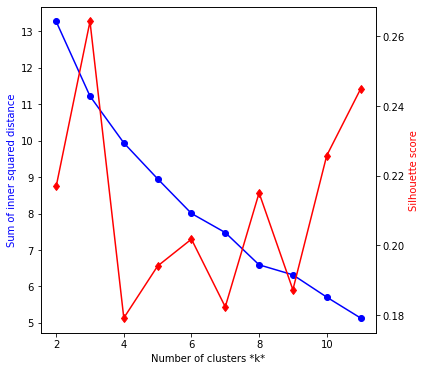

In [64]:
sil = []
sse = []
list_k = list(range(2,12))

for k in list_k:
    kmeans = KMeans(n_clusters = k, random_state=0)
    kmeans.fit(toulouse_grouped_clustering)
    sse.append(kmeans.inertia_)
    labels = kmeans.labels_
    sil.append(silhouette_score(toulouse_grouped_clustering, labels, metric='euclidean'))
    
fig, ax1 = plt.subplots(figsize=(6,6))

ax2 = ax1.twinx()
ax1.plot(list_k, sse, 'bo-')
ax2.plot(list_k, sil, 'rd-')

ax1.set_xlabel(r'Number of clusters *k*')
ax1.set_ylabel('Sum of inner squared distance', color='b')
ax2.set_ylabel('Silhouette score', color='r')

plt.show()

Recall that we here aim at reaching the highest silhouette score and minimizing the sum of inner squared distance. Accordingly, the most appropriate value for k is 11. 

In [65]:
#run k-means clustering
k=11

kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(toulouse_grouped_clustering)

kmeans.labels_[0:10] #check first labels

array([1, 1, 2, 4, 2, 5, 2, 2, 5, 2], dtype=int32)

In [66]:
metros_venues_sorted.insert(0, 'cluster_labels', kmeans.labels_)
metros_venues_sorted.head()

,cluster_labels,metro_station,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,ARENES,Train Station,BBQ Joint,Bakery,Fast Food Restaurant,Wine Bar,Event Space,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio
1,1,ARENES SAINT-CYPRIEN,Train Station,BBQ Joint,Bakery,Fast Food Restaurant,Wine Bar,Event Space,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio
2,2,ARGOULETS,Pool,Gas Station,Park,Wine Bar,Dog Run,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio
3,4,BAGATELLE,Bakery,Bus Stop,Wine Bar,Event Space,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Department Store,Dessert Shop
4,2,BALMA GRAMONT,Hobby Shop,Supermarket,French Restaurant,Fast Food Restaurant,Electronics Store,Mobile Phone Shop,Nightclub,Sandwich Place,Shopping Mall,Clothing Store


In [67]:
toulouse_merged = geo_metro

toulouse_merged = toulouse_merged.join(metros_venues_sorted.set_index('metro_station'), on='nom')

In [68]:
toulouse_merged = toulouse_merged.drop(['etat', 'commune'], axis=1)

toulouse_merged.head()

,nom,ligne,couvert,en_service,type,geometry,longitude,latitude,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BASSO CAMBO,A,Aérien,1993,Metro,POINT (1.39228 43.56996),1.392278,43.569961,2.0,Fast Food Restaurant,Construction & Landscaping,Shopping Mall,Bus Stop,Steakhouse,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio
1,REYNERIE,A,Souterrain,1993,Metro,POINT (1.40173 43.57093),1.401730,43.570927,0.0,Park,Wine Bar,Electronics Store,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Department Store,Dessert Shop
2,CAPITOLE,A,Souterrain,1993,Metro,POINT (1.44527 43.60435),1.445273,43.604350,2.0,French Restaurant,Plaza,Burger Joint,Coffee Shop,Hotel,Restaurant,Tea Room,Ice Cream Shop,Bar,Bookstore
3,ARGOULETS,A,Souterrain,2003,Metro,POINT (1.47674 43.62433),1.476740,43.624335,2.0,Pool,Gas Station,Park,Wine Bar,Dog Run,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio
4,UNIVERSITE PAUL SABATIER,B,Souterrain,2007,Metro,POINT (1.46310 43.56113),1.463097,43.561132,6.0,Bus Stop,Wine Bar,Event Space,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Department Store,Dessert Shop,Diner


In [69]:
toulouse_merged.dropna(inplace=True)

#transform cluster column in integers
toulouse_merged['cluster_labels'] = toulouse_merged['cluster_labels'].apply(np.int64)

---

### 4.2 Visualize results on a map

In [70]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [112]:
map_clusters = folium.Map(location=[latitude_T, longitude_T], zoom_start=13)

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lng, name, cluster in zip(toulouse_merged['latitude'], toulouse_merged['longitude'], toulouse_merged['nom'], toulouse_merged['cluster_labels']):
    label = folium.Popup(str(name) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
                        [lat, lng],
                        radius=5,
                        popup=label,
                        color=rainbow[cluster-1],
                        fill_opacity=0.9).add_to(map_clusters)

map_clusters

Let's add the existing movie theaters:

In [74]:
for lat, lng, label in zip(theaters['location.lat'], theaters['location.lng'], theaters['name']):
    folium.Marker(
        [lat, lng],
        popup=label).add_to(map_clusters)

map_clusters

The first thing we can identify visually is that there are a lot of movie theaters near cluster number 2 (dark blue). 

## 3. Analyse
we will now take census data as to identify neighborhoods that have more residents than others.

In [2]:
#get census informations
'''https://data.toulouse-metropole.fr/explore/dataset/recensement-population-2016-grands-quartiers-population/export/?location=12,43.63036,1.43303&basemap=jawg.streets'''

geo_data = r'recensement-population-2016-grands-quartiers-population.geojson'

In [3]:
census_data = geopandas.read_file(geo_data)
census_data.head()

,p16_phormen,p16_h0014,c16_h15p_cs8,libelle_des_grands_quartiers,p16_f1529,p16_pop1824,grd_quart,p16_h6074,p16_pop0014,code_insee,...,p16_pop0305,p16_pop6579,dep,p16_f65p,p16_f75p,p16_f0019,c16_h15p_cs4,reg2016,p16_pop75p,geometry
0,278.960032,205.520588,1009.239025,CAPITOLE,2001.991419,2561.761646,3155501,259.922283,430.622620,31555,...,96.864689,510.933609,31,378.305178,163.754321,878.817810,359.002454,76,274.692008,"POLYGON ((1.44565 43.60048, 1.44509 43.60045, ..."
1,6.999996,381.957022,815.200048,COMPANS,2036.572981,2423.163767,3155508,327.354920,707.662443,31555,...,144.979905,535.082501,31,496.974399,250.454235,674.969804,470.643339,76,338.217226,"POLYGON ((1.42190 43.60975, 1.42093 43.61011, ..."
2,202.999879,568.361045,475.471476,CROIX-DE-PIERRE,756.003591,782.866433,3155528,417.282456,1065.700161,31555,...,197.434800,704.971689,31,713.710943,419.770190,751.474917,453.102785,76,616.806453,"POLYGON ((1.42889 43.58416, 1.42806 43.58242, ..."
3,0.000000,407.350822,343.017663,FAOURETTE,472.052600,424.288090,3155530,254.803598,741.328897,31555,...,128.485762,451.491688,31,385.481141,218.532043,470.036485,100.849192,76,355.637900,"POLYGON ((1.41114 43.57915, 1.41204 43.57975, ..."
4,117.999930,597.032683,460.742171,LA CEPIERE,697.317733,750.113143,3155534,267.232357,1238.683965,31555,...,260.860970,572.243265,31,605.102168,368.142702,834.241469,311.166294,76,534.401630,"POLYGON ((1.40058 43.58828, 1.39995 43.58943, ..."


In [4]:
gdf = geopandas.GeoDataFrame(census_data, geometry=census_data.geometry)
gdf.crs = {'init': 'epsg:4326'}

/home/mateo/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Visulaize census data on a choropleth map

In [89]:
map_census = folium.Map(location=[latitude_T, longitude_T], zoom_start=12)

map_census.choropleth(
    geo_data=gdf,
    data=gdf,
    columns=['libelle_des_grands_quartiers', 'p16_pop'],
    key_on='feature.properties.libelle_des_grands_quartiers',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Population')
map_census

In [94]:
#add cinema
for lat, lng, label in zip(theaters['location.lat'], theaters['location.lng'], theaters['name']):
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        color='red',
        fill_color='red',
        fill_opacity='0.8',
        fill=True,
        popup=label).add_to(map_census)
    
map_census

In [95]:
#add clustered metro stations

x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lng, name, cluster in zip(toulouse_merged['latitude'], toulouse_merged['longitude'], toulouse_merged['nom'], toulouse_merged['cluster_labels']):
    label = folium.Popup(str(name) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
                        [lat, lng],
                        radius=5,
                        popup=label,
                        color=rainbow[cluster-1],
                        fill_opacity=0.7).add_to(map_census)

map_census

We now dive into the constituing venues in each cluster; in the following tables, we are able to see the most common venues for every metro stations, grouped by cluster labels. This will be the basis for the analysis provided in our report.

In [96]:
toulouse_merged.loc[toulouse_merged['cluster_labels'] == 0, toulouse_merged.columns[[1] + list(range(5, toulouse_merged.shape[1]))]]

,ligne,geometry,longitude,latitude,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,A,POINT (1.40173 43.57093),1.40173,43.570927,0,Park,Wine Bar,Electronics Store,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Department Store,Dessert Shop


In [97]:
toulouse_merged.loc[toulouse_merged['cluster_labels'] == 1, toulouse_merged.columns[[1] + list(range(5, toulouse_merged.shape[1]))]]

,ligne,geometry,longitude,latitude,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,A,POINT (1.42311 43.59642),1.423111,43.596420,1,African Restaurant,BBQ Joint,Falafel Restaurant,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Department Store,Dessert Shop,Diner
24,C,POINT (1.37182 43.59978),1.371823,43.599777,1,Health & Beauty Service,Train Station,Electronics Store,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Department Store
35,C,POINT (1.40145 43.59558),1.401452,43.595583,1,Soccer Field,Train Station,Wine Bar,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Department Store,Dessert Shop
37,A,POINT (1.41854 43.59339),1.418538,43.593390,1,Train Station,BBQ Joint,Bakery,Fast Food Restaurant,Wine Bar,Event Space,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio
43,C,POINT (1.41824 43.59399),1.418241,43.593987,1,Train Station,BBQ Joint,Bakery,Fast Food Restaurant,Wine Bar,Event Space,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio


In [98]:
toulouse_merged.loc[toulouse_merged['cluster_labels'] == 2, toulouse_merged.columns[[1] + list(range(5, toulouse_merged.shape[1]))]]

,ligne,geometry,longitude,latitude,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,A,POINT (1.39228 43.56996),1.392278,43.569961,2,Fast Food Restaurant,Construction & Landscaping,Shopping Mall,Bus Stop,Steakhouse,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio
2,A,POINT (1.44527 43.60435),1.445273,43.604350,2,French Restaurant,Plaza,Burger Joint,Coffee Shop,Hotel,Restaurant,Tea Room,Ice Cream Shop,Bar,Bookstore
3,A,POINT (1.47674 43.62433),1.476740,43.624335,2,Pool,Gas Station,Park,Wine Bar,Dog Run,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio
6,A,POINT (1.44985 43.60634),1.449854,43.606345,2,French Restaurant,Pub,Plaza,Bar,Pharmacy,Ice Cream Shop,Coffee Shop,Clothing Store,Cheese Shop,Department Store
7,A,POINT (1.48272 43.62931),1.482715,43.629314,2,Hobby Shop,Supermarket,French Restaurant,Fast Food Restaurant,Electronics Store,Mobile Phone Shop,Nightclub,Sandwich Place,Shopping Mall,Clothing Store
9,B,POINT (1.44563 43.59764),1.445625,43.597642,2,French Restaurant,Bar,Plaza,Café,Dessert Shop,Restaurant,Tapas Restaurant,Sushi Restaurant,Pub,Burger Joint
15,B,POINT (1.44863 43.60580),1.448634,43.605803,2,French Restaurant,Pub,Plaza,Bar,Pharmacy,Ice Cream Shop,Coffee Shop,Clothing Store,Cheese Shop,Department Store
18,B,POINT (1.44465 43.59232),1.444649,43.592324,2,Caribbean Restaurant,Restaurant,Tram Station,French Restaurant,Bus Stop,Ramen Restaurant,Hotel,Pub,Plaza,Supermarket
19,B,POINT (1.43435 43.61539),1.434348,43.615390,2,Wine Bar,Indian Restaurant,Event Space,Stadium,Italian Restaurant,Basketball Stadium,Jazz Club,Football Stadium,French Restaurant,Cosmetics Shop
20,A,POINT (1.43158 43.59797),1.431577,43.597970,2,Plaza,Supermarket,Tapas Restaurant,Sandwich Place,Pub,Farmers Market,Steakhouse,Gastropub,Burger Joint,Bar


In [99]:
toulouse_merged.loc[toulouse_merged['cluster_labels'] == 3, toulouse_merged.columns[[1] + list(range(5, toulouse_merged.shape[1]))]]

,ligne,geometry,longitude,latitude,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,C,POINT (1.38405 43.59659),1.384050,43.596595,3,Train Station,Wine Bar,Event Space,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Department Store,Dessert Shop
42,C,POINT (1.33377 43.60357),1.333767,43.603566,3,Train Station,Wine Bar,Event Space,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Department Store,Dessert Shop


In [100]:
toulouse_merged.loc[toulouse_merged['cluster_labels'] == 4, toulouse_merged.columns[[1] + list(range(5, toulouse_merged.shape[1]))]]

,ligne,geometry,longitude,latitude,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,A,POINT (1.41232 43.58000),1.412318,43.580001,4,Bakery,Bus Stop,Wine Bar,Event Space,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Department Store,Dessert Shop
14,A,POINT (1.46962 43.61998),1.469623,43.619980,4,Lounge,Indian Restaurant,Bus Stop,Wine Bar,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Department Store,Dessert Shop
34,B,POINT (1.44461 43.63799),1.444612,43.637995,4,Home Service,Bus Stop,Event Space,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Department Store,Dessert Shop,Diner
39,B,POINT (1.44211 43.57985),1.442112,43.579854,4,Football Stadium,Bus Stop,Wine Bar,Event Space,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Department Store,Dessert Shop


In [101]:
toulouse_merged.loc[toulouse_merged['cluster_labels'] == 5, toulouse_merged.columns[[1] + list(range(5, toulouse_merged.shape[1]))]]

,ligne,geometry,longitude,latitude,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,B,POINT (1.43556 43.63372),1.435560,43.633717,5,Pizza Place,Supermarket,Bus Station,Photography Studio,Garden,Dessert Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop
10,C,POINT (1.35313 43.60253),1.353128,43.602527,5,Supermarket,Train Station,French Restaurant,Wine Bar,Electronics Store,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio
16,B,POINT (1.45260 43.64065),1.452600,43.640649,5,Supermarket,Bus Station,Concert Hall,Wine Bar,Electronics Store,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio
22,B,POINT (1.44999 43.58039),1.449993,43.580386,5,Supermarket,Gastropub,Train Station,Asian Restaurant,Dance Studio,Wine Bar,Electronics Store,Convenience Store,Cosmetics Shop,Creperie
32,B,POINT (1.43586 43.62034),1.435865,43.620338,5,Supermarket,Optical Shop,Wine Bar,Electronics Store,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Department Store
33,B,POINT (1.43396 43.62674),1.433962,43.626745,5,Supermarket,Brewery,Wine Bar,Electronics Store,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Department Store


In [102]:
toulouse_merged.loc[toulouse_merged['cluster_labels'] == 6, toulouse_merged.columns[[1] + list(range(5, toulouse_merged.shape[1]))]]

,ligne,geometry,longitude,latitude,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,B,POINT (1.46310 43.56113),1.463097,43.561132,6,Bus Stop,Wine Bar,Event Space,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Department Store,Dessert Shop,Diner
17,B,POINT (1.47637 43.55577),1.476372,43.555768,6,Bus Stop,Wine Bar,Event Space,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Department Store,Dessert Shop,Diner


In [103]:
toulouse_merged.loc[toulouse_merged['cluster_labels'] == 7, toulouse_merged.columns[[1] + list(range(5, toulouse_merged.shape[1]))]]

,ligne,geometry,longitude,latitude,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,B,POINT (1.46170 43.57484),1.461701,43.574843,7,Convenience Store,Diner,Wine Bar,Event Space,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Department Store,Dessert Shop


In [104]:
toulouse_merged.loc[toulouse_merged['cluster_labels'] == 8, toulouse_merged.columns[[1] + list(range(5, toulouse_merged.shape[1]))]]

,ligne,geometry,longitude,latitude,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,B,POINT (1.44715 43.58636),1.447146,43.586359,8,Pub,Wine Bar,Electronics Store,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Department Store,Dessert Shop


In [105]:
toulouse_merged.loc[toulouse_merged['cluster_labels'] == 9, toulouse_merged.columns[[1] + list(range(5, toulouse_merged.shape[1]))]]

,ligne,geometry,longitude,latitude,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,A,POINT (1.40200 43.57467),1.402002,43.574673,9,Hostel,Photography Studio,Wine Bar,Electronics Store,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Department Store


In [106]:
toulouse_merged.loc[toulouse_merged['cluster_labels'] == 10, toulouse_merged.columns[[1] + list(range(5, toulouse_merged.shape[1]))]]

,ligne,geometry,longitude,latitude,cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
29,B,POINT (1.46450 43.56812),1.464501,43.568116,10,Restaurant,Wine Bar,Electronics Store,Convenience Store,Cosmetics Shop,Creperie,Cupcake Shop,Dance Studio,Department Store,Dessert Shop


A detailed analysis of those results is provided in the report

---